In [1]:
from time import time
import keras
import os
import sys
sys.path.append('../')
from utils.utils import smooth_labels, CLRScheduler, LinearDecayScheduler, WarmUpCosineDecayScheduler
from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel

from utils.codification_skipc import FitnessSkip, Connections, ChromosomeSkip
from utils.datamanager import DataManager
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline


def get_chromosome_from_file(filename):
    cnn_layers = []
    nn_layers = []
    connections = []
    with open(filename, 'r') as f:
        for line in f:
            params = line.split('|')            
            if 'CNN' == params[0]:
                filters = int(params[1].split(':')[1])
                kernel = literal_eval(params[2].split(':')[1])
                activation = params[3].split(':')[1]
                dropout = float(params[4].split(':')[1])
                maxpool = bool(int(params[5].split(':')[1]))
                cnn_layers.append(CNNLayer(filters, kernel, activation, dropout, maxpool))
            elif 'NN' == params[0]:
                units = int(params[1].split(':')[1])
                activation = params[2].split(':')[1]
                dropout = float(params[3].split(':')[1])
                nn_layers.append(NNLayer(units, activation, dropout))
            else:
                try:
                    local_connections = [int(el) for el in params[0].split("\n")[0]]
                    if len(local_connections) > 0:
                        connections.append(local_connections)
                except ValueError:
                    pass
        max_len = np.max([len(e) for e in connections])
        matrix = np.array([el + [0] * (max_len - len(el)) for el in connections])
        connections = Connections(matrix)
    return ChromosomeSkip(cnn_layers, nn_layers, connections)


def show_result(history, metric='acc'):
        color = np.array([[31, 119, 180], [255, 127, 14]]) / 255.
        try:
            epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
            argmax_val = np.argmax(history.history['val_%s' % metric])
            plt.plot(epochs, history.history['val_%s' % metric], label='validation', color=color[0], alpha=0.5)
            plt.plot(epochs, median_filter(history.history['val_%s' % metric]), color=color[0])
            plt.scatter(epochs[argmax_val], history.history['val_%s' % metric][argmax_val],
            label='max val_%s %0.4f' % (metric, history.history['val_%s' % metric][argmax_val]), c='r')
        except KeyError:
            pass
        plt.plot(epochs, history.history[metric], label='train', color=color[1], alpha=0.5)
        plt.plot(epochs, median_filter(history.history[metric]), color=color[1])


        plt.legend()
        plt.xlabel('Epochs')
        #plt.xticks([20, 40, 60, 80, 120, 160, 180])
        plt.grid()
        plt.ylabel(metric)
        plt.show()
        
def median_filter(v, size=5):
    stride = (size - 1) // 2
    filtered_v = []
    for i in range(len(v)):
        if i < stride or i + stride == len(v):
            filtered_v.append(v[i])
        else:
            filtered_v.append(np.mean(v[i-stride:i + stride + 1]))
    return filtered_v


data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./train_gen.py'
verbose = 1
experiments_folder = '../super_conv'
gpus = 1

Using TensorFlow backend.


In [2]:
# dataset params:
data_folder = data_folder
smooth = 0.1
classes = []

dataset = 'MRDBI'
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
(x_train, y_train), (x_test, y_test), (x_val, y_val) = dm.load_data()


if smooth > 0:
    y_train = smooth_labels(y_train, smooth)

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


In [3]:
# Fitness params
epochs = 15
batch_size = 128
base_lr = 0.001
smooth = 0.1

In [4]:
keras.backend.clear_session()

f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 1

c = get_chromosome_from_file('./models/%s' % dataset)
model = f.decode(c, dropout_voting=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 57)   5

In [5]:
# Create the Learning rate scheduler.
total_steps = int(epochs * y_train.shape[0] / batch_size)

clr = CLRScheduler(min_lr=0.00003,
                   max_lr=0.03,
                   total_steps=total_steps,
                   cycles=epochs//5)

callbacks = [clr]

In [6]:
ti = time()

h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks,
          verbose=1)
    
# score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Elapsed time: %0.2f" % ((time() - ti) / 60.))

Instructions for updating:
Use tf.cast instead.
Train on 9600 samples, validate on 2400 samples
Epoch 1/15
9600/9600 [==============================] - 34s 4ms/step - loss: 2.4748 - acc: 0.2550 - val_loss: 1.4353 - val_acc: 0.5108
Epoch 2/15
9600/9600 [==============================] - 28s 3ms/step - loss: 1.4981 - acc: 0.5770 - val_loss: 1.2209 - val_acc: 0.6400
Epoch 3/15
9600/9600 [==============================] - 28s 3ms/step - loss: 1.1964 - acc: 0.7234 - val_loss: 0.7223 - val_acc: 0.7733
Epoch 4/15
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9605 - acc: 0.8322 - val_loss: 0.5389 - val_acc: 0.8379
Epoch 5/15
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8389 - acc: 0.8873 - val_loss: 0.4945 - val_acc: 0.8638
Epoch 6/15
9600/9600 [==============================] - 28s 3ms/step - loss: 0.7992 - acc: 0.9106 - val_loss: 0.5237 - val_acc: 0.8496
Epoch 7/15
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8558 - acc: 0.8

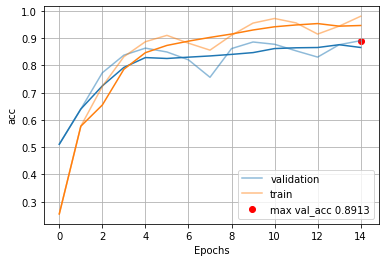

In [7]:
show_result(h)


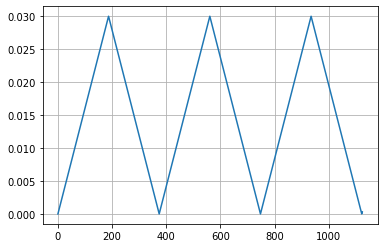

In [8]:
plt.plot(callbacks[0].learning_rates)
plt.grid()
plt.show()

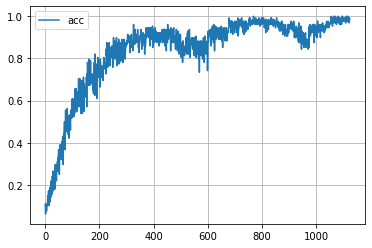

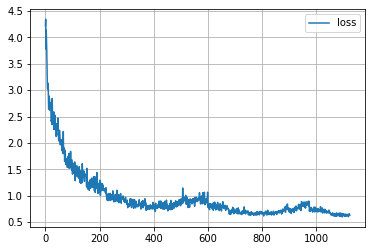

In [9]:
plt.plot(callbacks[0].accs, label='acc')
plt.legend()
plt.grid()
plt.show()
plt.plot(callbacks[0].losses, label='loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
def eval_predictions(preds, y_true):
    return np.sum(np.argmax(preds, axis=1) == np.argmax(y_true, axis=1))/y_true.shape[0]


In [23]:
def eval_voting(model, x, y, n_votes):
    predictions = [model.predict(x) for _ in range(n_votes)]
    singles_accs = [eval_predictions(pred, y) for pred in predictions]
    predictions = np.array(predictions)
    voting_predictions = [eval_predictions(np.mean(predictions[0:n], axis=0), y)
                      for n in range(1, n_votes + 1)]
    singles_mean = [np.mean(singles_accs[0:n]) for n in range(1,n_votes + 1)]
    print("Single accuracies:", singles_accs)
    print("N votes\t\tvoting\t\tsingles mean")
    for i in range(n_votes):
        print("%d\t\t%0.2f\t\t%0.2f" % (i+1, voting_predictions[i]*100, singles_mean[i]*100))

In [12]:
eval_voting(model, x_val, y_val, 5)

Single accuracies: [0.89125, 0.89125, 0.89125, 0.89125, 0.89125]
N votes		voting		singles mean
1		89.12		89.12
2		89.12		89.12
3		89.12		89.12
4		89.12		89.12
5		89.12		89.12


In [13]:
model.save_weights('model')

In [14]:
del model
model = f.decode(c, dropout_voting=True)
model.load_weights('model')

Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 28, 28, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 57)   570         batch_normalization_9[0][0]      
__________________________________________________________________________________________________
p_re_lu_5 (PReLU)               (None, 28, 

In [16]:
eval_voting(model, x_val, y_val, 15)

Single accuracies: [0.8629166666666667, 0.8679166666666667, 0.8620833333333333, 0.8645833333333334, 0.8654166666666666, 0.86, 0.85625, 0.8641666666666666, 0.8558333333333333, 0.8708333333333333, 0.8633333333333333, 0.8620833333333333, 0.8654166666666666, 0.86375, 0.8645833333333334]
N votes		voting		singles mean
1		86.29		86.29
2		87.58		86.54
3		88.29		86.43
4		88.50		86.44
5		88.67		86.46
6		88.58		86.38
7		88.62		86.27
8		88.71		86.29
9		88.46		86.21
10		88.79		86.30
11		88.88		86.30
12		88.92		86.30
13		88.79		86.31
14		88.79		86.32
15		88.92		86.33


#### Eval test set

In [25]:
del model
model = f.decode(c, dropout_voting=False)
model.load_weights('model')

Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 28, 28, 1)    4           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 57)   570         batch_normalization_33[0][0]     
__________________________________________________________________________________________________
p_re_lu_17 (PReLU)              (None, 28, 

In [26]:
eval_voting(model, x_test, y_test, 1)

Single accuracies: [0.88734]
N votes		voting		singles mean
1		88.73		88.73


In [20]:
del model
model = f.decode(c, dropout_voting=True)
model.load_weights('model')

Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
Input connections: 2
Maxpool times: 1
Maxpool times: 1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 28, 28, 1)    4           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 28, 28, 57)   570         batch_normalization_25[0][0]     
__________________________________________________________________________________________________
p_re_lu_13 (PReLU)              (None, 28, 

In [24]:
eval_voting(model, x_test, y_test, 5)

Single accuracies: [0.85924, 0.85944, 0.85986, 0.8594, 0.86018]
N votes		voting		singles mean
1		85.92		85.92
2		87.17		85.93
3		87.72		85.95
4		88.04		85.95
5		88.11		85.96
